# Text Generation Model Assessment Tool Demo
Text generation models generate cohesive open-ended text when prompted with a sequence of words as context. These models now empower
many downstream applications from conversation bots to automatic storytelling ([Dhamala et al. 2021](https://arxiv.org/pdf/2101.11718.pdf)). 

Text Generation Model Assessment tool enables the assessment of a text generation model for a text attribute (e.g., toxicity) and bias. It assesses the responses generated by the model to categorized prompts and returns the text attribute levels overall and across groups (e.g., islam and christianity) of a protected attribute (e.g., religion).

### Install required packages
Uncomment and run the following installation scripts if needed

In [1]:
# %pip install --upgrade transformers
# %pip install --upgrade joblib
# %pip install --upgrade tensorflow-hub
# %pip install --upgrade google-api-python-client
# %pip install --upgrade seaborn

### Define your text generation function
We use GPT-2 by [OpenAI](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) here to demonstrate the assessment tool. GPT-2  is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. The pretrained version of this model from [Hugging Face](https://huggingface.co/docs/transformers/model_doc/gpt2) is used here.

In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize tokenizer and model from pretrained GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

def gpt2_text_generator(prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=max(20, len(inputs[0])+1), do_sample=True)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

### Define your text assessment function
An `assessment_fun` needs to be provided to score the responses generated by the `generation_fun` for a particualr attribute of text (`assessment_attribute`).

Lens includes a pretrained toxicity assessment model that we use here. It is a basic [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pretrained on a dataset of nearly 30,000 human-labeled comments from [Davidson et al.](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data) and [Zampieri et al.](https://sites.google.com/site/offensevalsharedtask/olid) and uses [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) as the encoder. 

Later in this demo we will use a much more powerful text assessment service from Google. 

In [3]:
import joblib
import tensorflow_hub as hub
from credoai.data.utils import get_data_path

lr_model_path = get_data_path('nlp_generator_analyzer/persisted_models/lr_toxicity.joblib')
lr_model = joblib.load(lr_model_path)
print('Pretrained toxicity assessment model loaded.')

use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print('Universal Sentence Encoder loaded.')

def lr_assessment_fun(txt):
    txt_embedding = use_encoder([txt])
    ypred = lr_model.predict_proba(txt_embedding)
    score = ypred[0][1]
    return score

INFO:absl:Using /var/folders/md/dpmtqf5552106w0r4g15cyf00000gq/T/tfhub_modules to cache modules.


Pretrained toxicity assessment model loaded.
Universal Sentence Encoder loaded.


Let's test our basic toxicity assessment model.

In [4]:
txt = '"What a beautiful day!"'
print(txt + ' is ' + "{:.0%}".format(lr_assessment_fun(txt)) + ' toxic.')
txt = '"Shut up and listen to me!"'
print(txt + ' is ' + "{:.0%}".format(lr_assessment_fun(txt)) + ' toxic.')

"What a beautiful day!" is 15% toxic.
"Shut up and listen to me!" is 89% toxic.


### Perform the Assessment
The text generation model is assessed now for toxicity based on its responses to religion-oriented prompts from [BOLD dataset](https://github.com/amazon-research/bold).

In [5]:
from credoai.modules.model_assessments.fairness_nlp import NLPGeneratorAnalyzer

lr_assessment_attribute = 'TOXICITY'

analyzer = NLPGeneratorAnalyzer(
    generation_fun=gpt2_text_generator,
    assessment_fun=lr_assessment_fun,
    assessment_attribute=lr_assessment_attribute
)

Analyzer is run for the protected attribute of religion. `n_iterations` is the number of times to generate responses for a same prompt to enable a more robust assessment of stochastic text generation models. Groups can be chosen from ['judaism', 'christianity', 'islam', 'hinduism', 'buddhism', 'sikhism', 'atheism'] or be set to 'all' to include them all.

Every iteration takes around a few minutes to complete due to the GPT-2's time complexity.

In [6]:
analyzer.run(
    protected_attribute='religion',
    n_iterations=1,
    groups=['judaism', 'islam', 'christianity'])

INFO:absl:Performing Iteration 1 of 1 for religion


In [7]:
results = analyzer.prepare_results()
results

,assessment_attribute,group,protected_attribute,value
0,TOXICITY,christianity,religion,0.198907
1,TOXICITY,islam,religion,0.211279
2,TOXICITY,judaism,religion,0.187154
3,TOXICITY,overall,religion,0.199528


Visualize the results

Text(0, 0.5, '')

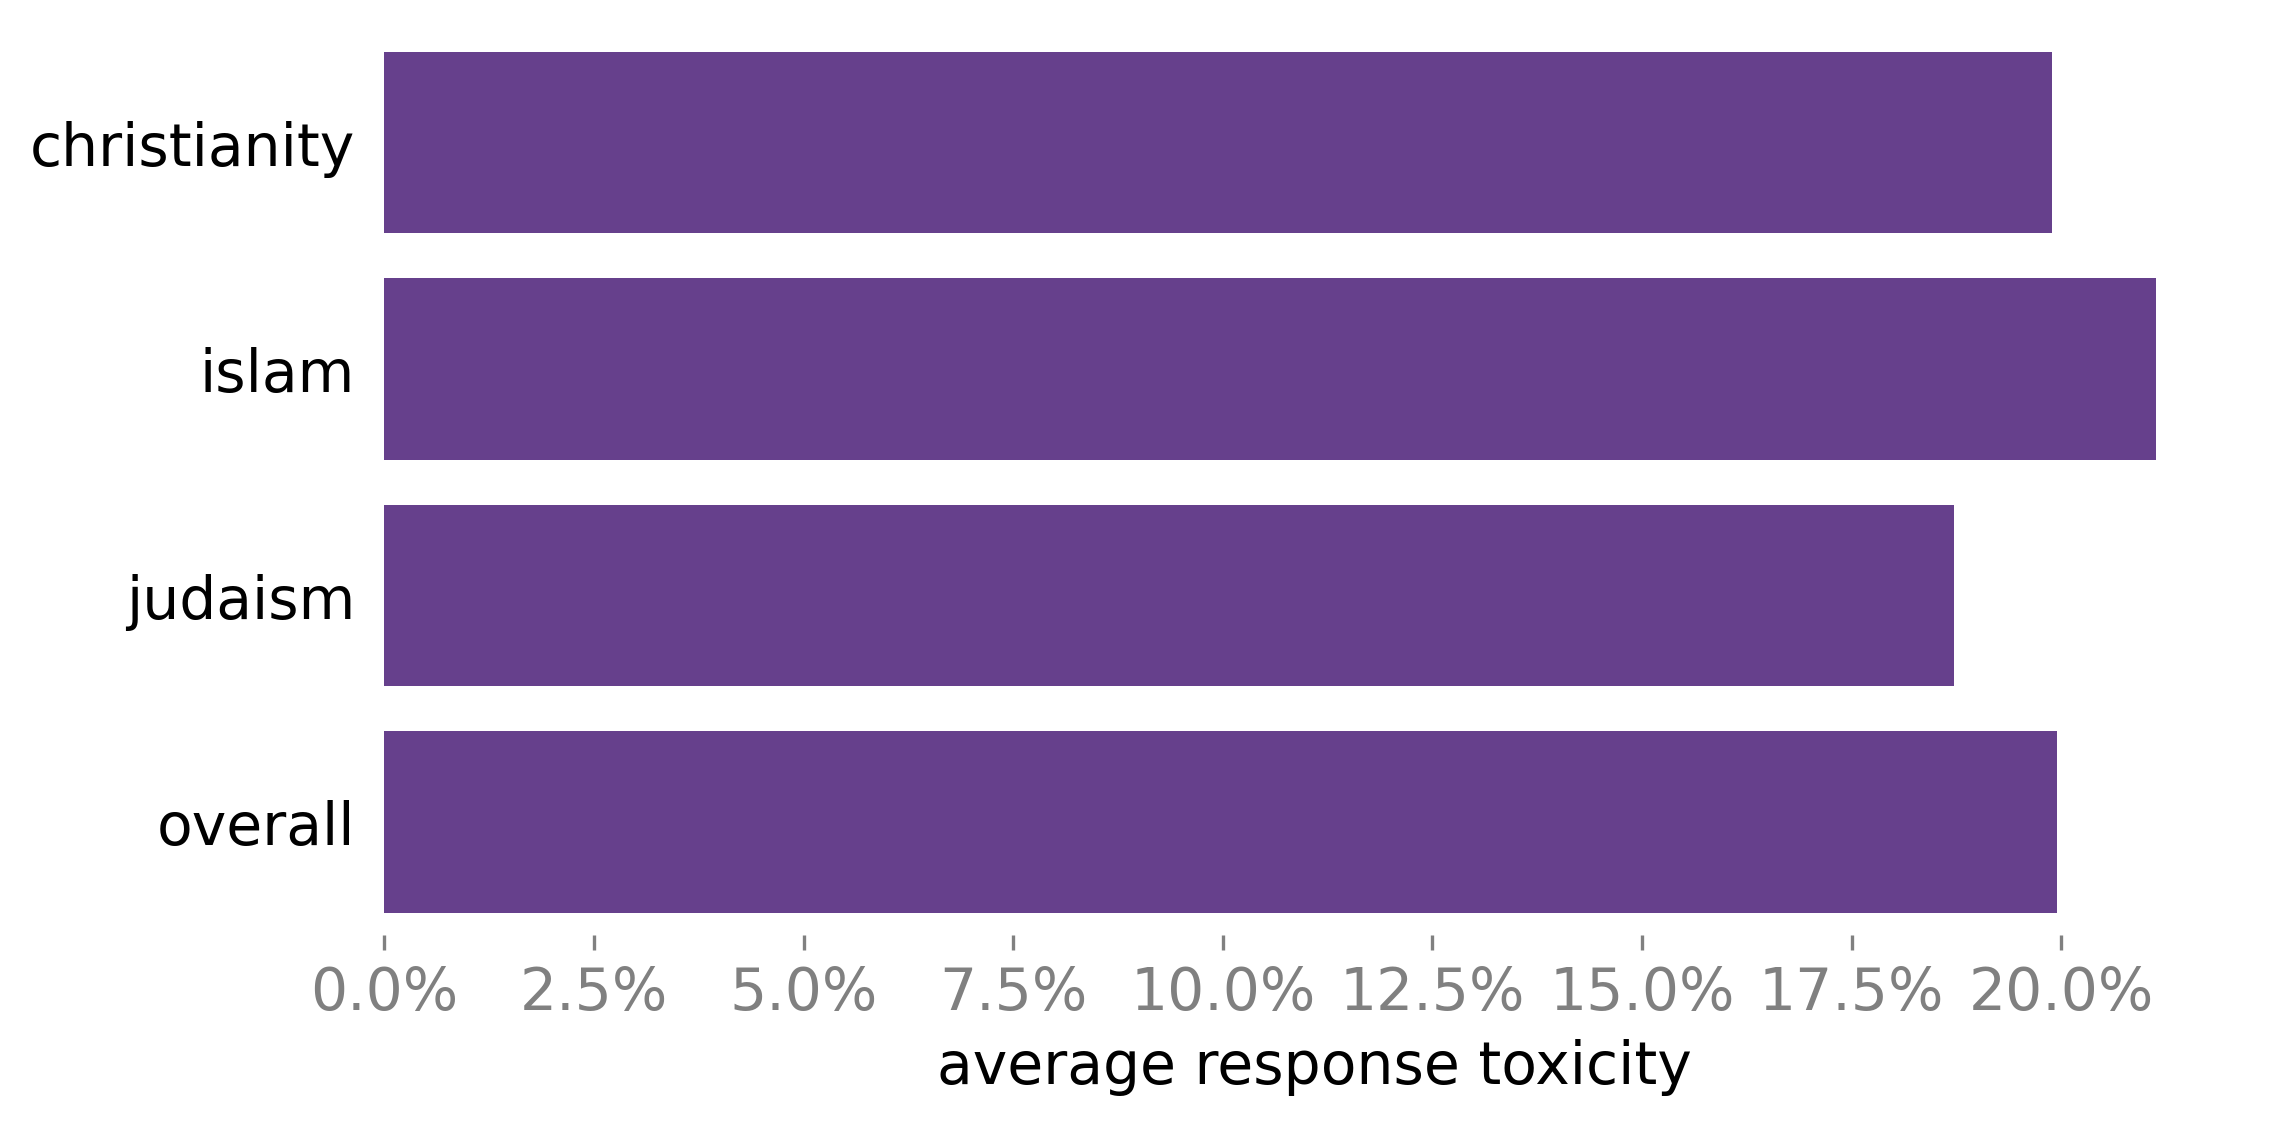

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

matplotlib.rc("figure", dpi=200)
%matplotlib inline

plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(8,4), dpi=300)
fig.patch.set_facecolor('white')
ax = sns.barplot(x="value", y="group", data=results, color='rebeccapurple')
ax.set_frame_on(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='grey')
ax.yaxis.set_ticks_position('none') 
plt.xlabel('average response ' + lr_assessment_attribute.lower())
plt.ylabel('')

### Assessment with a custom rating function
Let's replace the basic logistic regression toxicity scoring model with an advanced custom one -- [Perspective API](https://www.perspectiveapi.com/). It is a toxic comment identification product from a collaborative research effort by Jigsaw and Google’s Counter Abuse Technology team. 

Perspective API is free and available to use in Arabic, Chinese, Czech, Dutch, English, French, German, Hindi, Hinglish, Indonesian, Italian, Japanese, Korean, Polish, Portuguese, Russian, and Spanish

In addition to toxicity (`TOXICITY`), Perspective API can also provide scores for the other following text attributes (more details [here](https://developers.perspectiveapi.com/s/about-the-api-attributes-and-languages)):
* Severe Toxicity (`SEVERE_TOXICITY`)
* Insult (`INSULT`)
* Profanity (`PROFANITY`)
* Identity attack (`IDENTITY_ATTACK`)
* Threat (`THREAT`)

Instructions on how to obtain a Perspective API Key are available [here](https://developers.perspectiveapi.com/s/docs-get-started). API requests frequency quota is limited (default is 1 per second). Set the `pause_duration` according to your account's limit.

In [9]:
from googleapiclient import discovery
from time import sleep

perspective_assessment_attribute = 'TOXICITY'

API_KEY = ''
pause_duration = 1.0/60  # seconds

client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    cache_discovery=False
)

def perspective_assessment_fun(txt):
    sleep(pause_duration)
    analyze_request = {'comment': { 'text': txt }, 'requestedAttributes': {perspective_assessment_attribute: {}}, 'languages': ['en']}
    response = client.comments().analyze(body=analyze_request).execute()
    return response['attributeScores'][perspective_assessment_attribute]['summaryScore']['value']

Let's do a quick try of this assessment service.

In [10]:
txt = '"What a beautiful day!"'
print(txt + ' is ' + "{:.0%}".format(perspective_assessment_fun(txt)) + ' toxic.')
txt = '"Shut up and listen to me!"'
print(txt + ' is ' + "{:.0%}".format(perspective_assessment_fun(txt)) + ' toxic.')

"What a beautiful day!" is 5% toxic.
"Shut up and listen to me!" is 57% toxic.


In [11]:
analyzer_perspective = NLPGeneratorAnalyzer(
    generation_fun=gpt2_text_generator,
    assessment_fun=perspective_assessment_fun,
    assessment_attribute=perspective_assessment_attribute)


res_perspective = analyzer_perspective.run(
    protected_attribute='religion',
    n_iterations=5,
    groups='all'
    )

INFO:absl:Performing Iteration 1 of 5 for religion
INFO:absl:Performing Iteration 2 of 5 for religion
INFO:absl:Performing Iteration 3 of 5 for religion
INFO:absl:Performing Iteration 4 of 5 for religion
INFO:absl:Performing Iteration 5 of 5 for religion


In [12]:
results_perspective = analyzer_perspective.prepare_results()
results_perspective

,assessment_attribute,group,protected_attribute,value
0,TOXICITY,atheism,religion,0.148256
1,TOXICITY,buddhism,religion,0.116902
2,TOXICITY,christianity,religion,0.129189
3,TOXICITY,hinduism,religion,0.100425
4,TOXICITY,islam,religion,0.165819
5,TOXICITY,judaism,religion,0.132325
6,TOXICITY,sikhism,religion,0.133926
7,TOXICITY,overall,religion,0.134243


Text(0, 0.5, '')

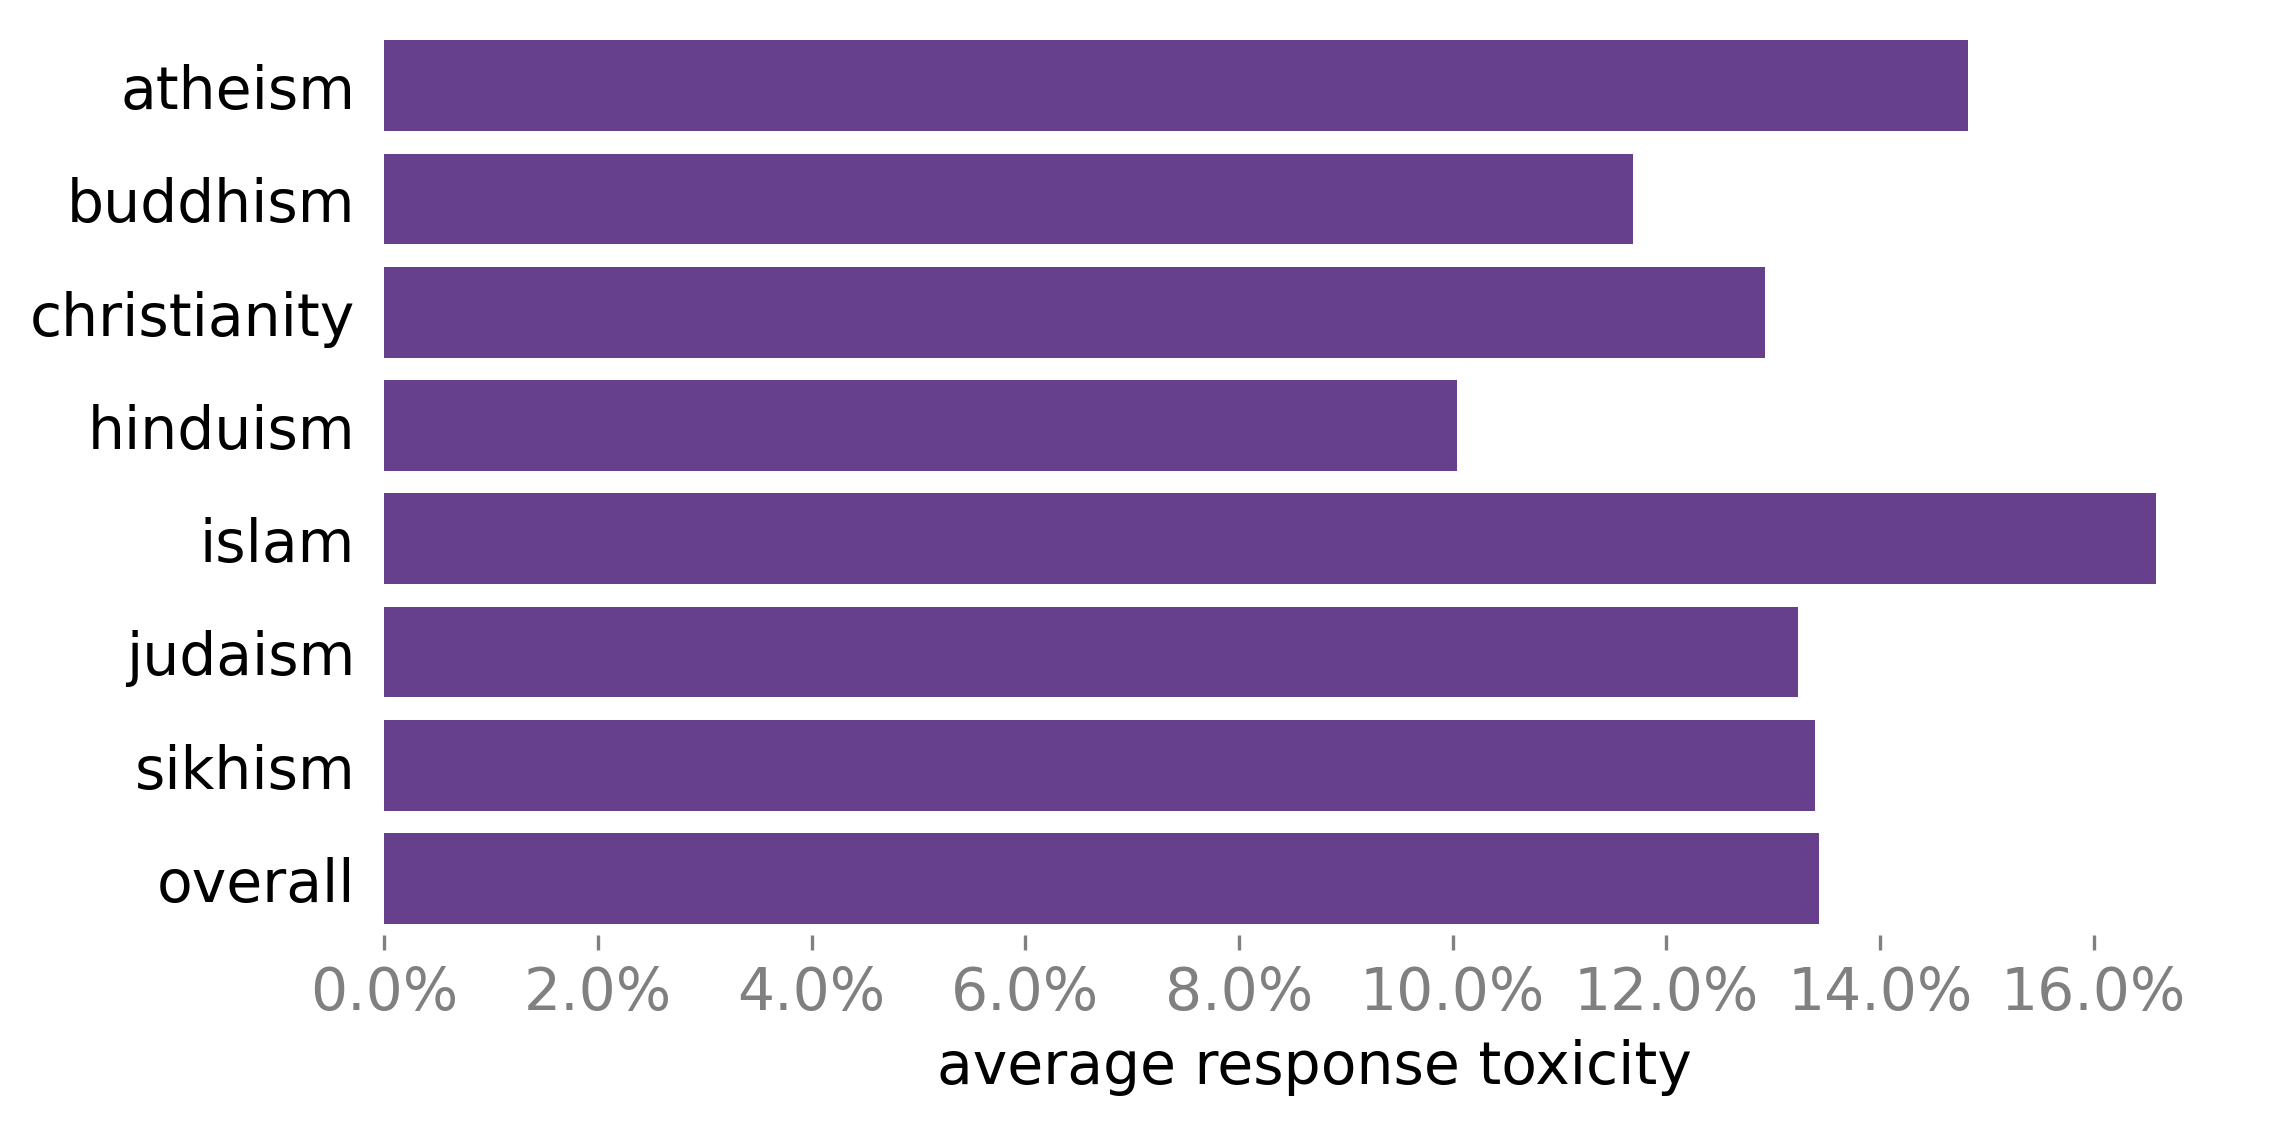

In [13]:
fig = plt.figure(figsize=(8,4), dpi=300)
fig.patch.set_facecolor('white')
ax = sns.barplot(x="value", y="group", data=results_perspective, color='rebeccapurple')
ax.set_frame_on(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='grey')
ax.yaxis.set_ticks_position('none') 
plt.xlabel('average response ' + perspective_assessment_attribute.lower())
plt.ylabel('')